## janesick_nature_comms_2023, sample2

### Initialize

In [11]:
import numpy as np
from ome_types import from_tiff
from cv2 import perspectiveTransform
def get_xenium_to_morphology_transform_from_xenium_morphology_image(
    morphology_path: str, pyramid_level: int = 0
) -> np.ndarray[np.float32]:
    """
    The Xenium coordinate system has its origin at (0,0) set to the top left of the Xenium morphology image.
    The image coordinate system is in uM and must be converted to px. This produces a transformation matrix for
    that conversion.

    https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors-
    """
    morphology_metadata = from_tiff(morphology_path)
    origin_x = morphology_metadata.plates[0].well_origin_x
    origin_y = morphology_metadata.plates[0].well_origin_y
    physical_size_x = morphology_metadata.images[0].pixels.physical_size_x
    physical_size_y = morphology_metadata.images[0].pixels.physical_size_y
    ##Homography matrix describing scaling by pixel-size and translating by offset.
    return np.array(
        [
            [1 / physical_size_x / 2**pyramid_level, 0, 0],
            [0, 1 / physical_size_y / 2**pyramid_level, 0],
            [0, 0, 1],
        ]
    )



def transform_coordinates(
    coords: np.ndarray[np.float32, (None, 2)], transform_matrix: np.ndarray[np.float32]
) -> np.ndarray[np.float32, (None, 2)]:
    """Transforms coordinates using transform.
    https://en.wikipedia.org/wiki/Homography_(computer_vision)
    """
    return perspectiveTransform(
        coords.reshape(-1, 1, 2).astype(np.float32), transform_matrix
    )[:, 0, :]


In [18]:
from pathlib import Path
import pandas as pd
xenium_sp2_path = Path("../data/janesick_nature_comms_2023/xenium_sample2/Xenium_V1_FFPE_Preview_Human_Breast_Cancer_Sample_2_outs/").expanduser()
annot_path = Path("../data/janesick_nature_comms_2023/GSE243275_Barcode_Cell_Type_Matrices.xlsx").expanduser()

In [3]:
import time
proj_name = "janesick_nc_2023_dev_sample2"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/janesick_nature_comms_2023/"
data_dir = Path(data_dir)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

'Jun05-2014'

### IO for Xenium data

In [19]:
from tifffile import imread

## Read in Xenium transcript data and decode the bytes column to string
xenium_sp2_transcripts = pd.read_parquet(xenium_sp2_path / "transcripts.parquet")
xenium_sp2_transcripts.feature_name = xenium_sp2_transcripts.feature_name.str.decode("utf-8")

## Read in the Xenium cell positions and cell metadata.
xenium_sp2_cell_info = pd.read_csv(xenium_sp2_path / "cells.csv.gz").set_index(
    "cell_id"
)

## Read in the Xenium morphology (DAPI) MIP image. Note: We are reading the image at the resolution of
## the third pyramid level: full_resolution / 2 ** 3. We are using this image for plotting.
## The Xenium imaging area is large, and the full resolution image is large enough to be slow to plot.
## Working with a lower resolution image when possible is a convenience.
pyramid_level = 3
xenium_sp2_morphology_mip_at_pyramid_level = imread(
    xenium_sp2_path / "morphology_mip.ome.tif", series=0, level=pyramid_level
)

## Read in the nucleus boundary polygon information. Xenium polygons are a plotting convenience and should not
## be used for analysis. A nucleus mask is provided for analysis of Xenium segmentation.
xenium_sp2_nucleous_boundaries_df = pd.read_parquet(
    xenium_sp2_path / "nucleus_boundaries.parquet"
)

## Transformation matrix to transform from the Xenium coordinate system to the morphology image coordinate system
## at pyramid level. Determined using the pixel size of the morphology image. 
xenium_to_morphology_at_pyramid_transformation = (
    get_xenium_to_morphology_transform_from_xenium_morphology_image(
        xenium_sp2_path / "morphology_mip.ome.tif", pyramid_level
    )
)

## Cell type assignments as determined by label transfer from a matched FLEX dataset.
## This is a supplemental file provided within the publication.
## barcode X celltype
xenium_sp2_celltype_df = pd.read_excel(
    annot_path,
    sheet_name="Xenium Fig 6 (unsupervised)",
    index_col=0,
)


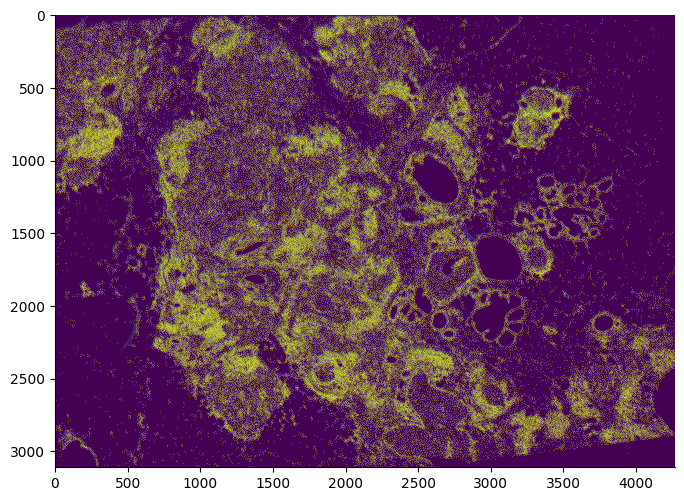

In [20]:
## data setup
## get Xenium coordinates -> transformed into Xenium morphology pixel coordinates
from matplotlib import pyplot as plt
coords = transform_coordinates(
    xenium_sp2_cell_info[["x_centroid", "y_centroid"]].values,
    xenium_to_morphology_at_pyramid_transformation,
)

## plot style setup
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

## plotting code
ax.imshow(xenium_sp2_morphology_mip_at_pyramid_level)
ax.scatter(*coords.T, s=0.1, linewidth=0, edgecolor=None, marker="o", color="yellow")

## plot style adjustments
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

### Xenium adata analysis

In [21]:
import scanpy as sc

# Load data
xenium_sp2_adata = sc.read_10x_h5(xenium_sp2_path / "cell_feature_matrix.h5")
# concat xenium_cell_info, xenium_celltype_df to xenium_adata.obs
xenium_sp2_adata.obs = xenium_sp2_cell_info.join(xenium_sp2_celltype_df, how='left')
# Add the cell type as a categorical variable
xenium_sp2_adata.obs['annot_cell_type'] = xenium_sp2_adata.obs['Cluster'].astype('category')
xenium_sp2_adata.layers['counts'] = xenium_sp2_adata.X.copy()

In [23]:
# Normalize visium_adata
xenium_sp2_adata.layers['counts'] = xenium_sp2_adata.X.copy()
sc.pp.normalize_total(xenium_sp2_adata, target_sum=1e4)
# log transform
sc.pp.log1p(xenium_sp2_adata)
# PCA and UMAP
n_latent = 30
sc.pp.pca(xenium_sp2_adata, n_comps=n_latent, svd_solver='arpack')
sc.pp.neighbors(xenium_sp2_adata, n_neighbors=15, n_pcs=n_latent)
sc.tl.umap(xenium_sp2_adata, min_dist=0.1, n_components=2)

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: invalid value encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


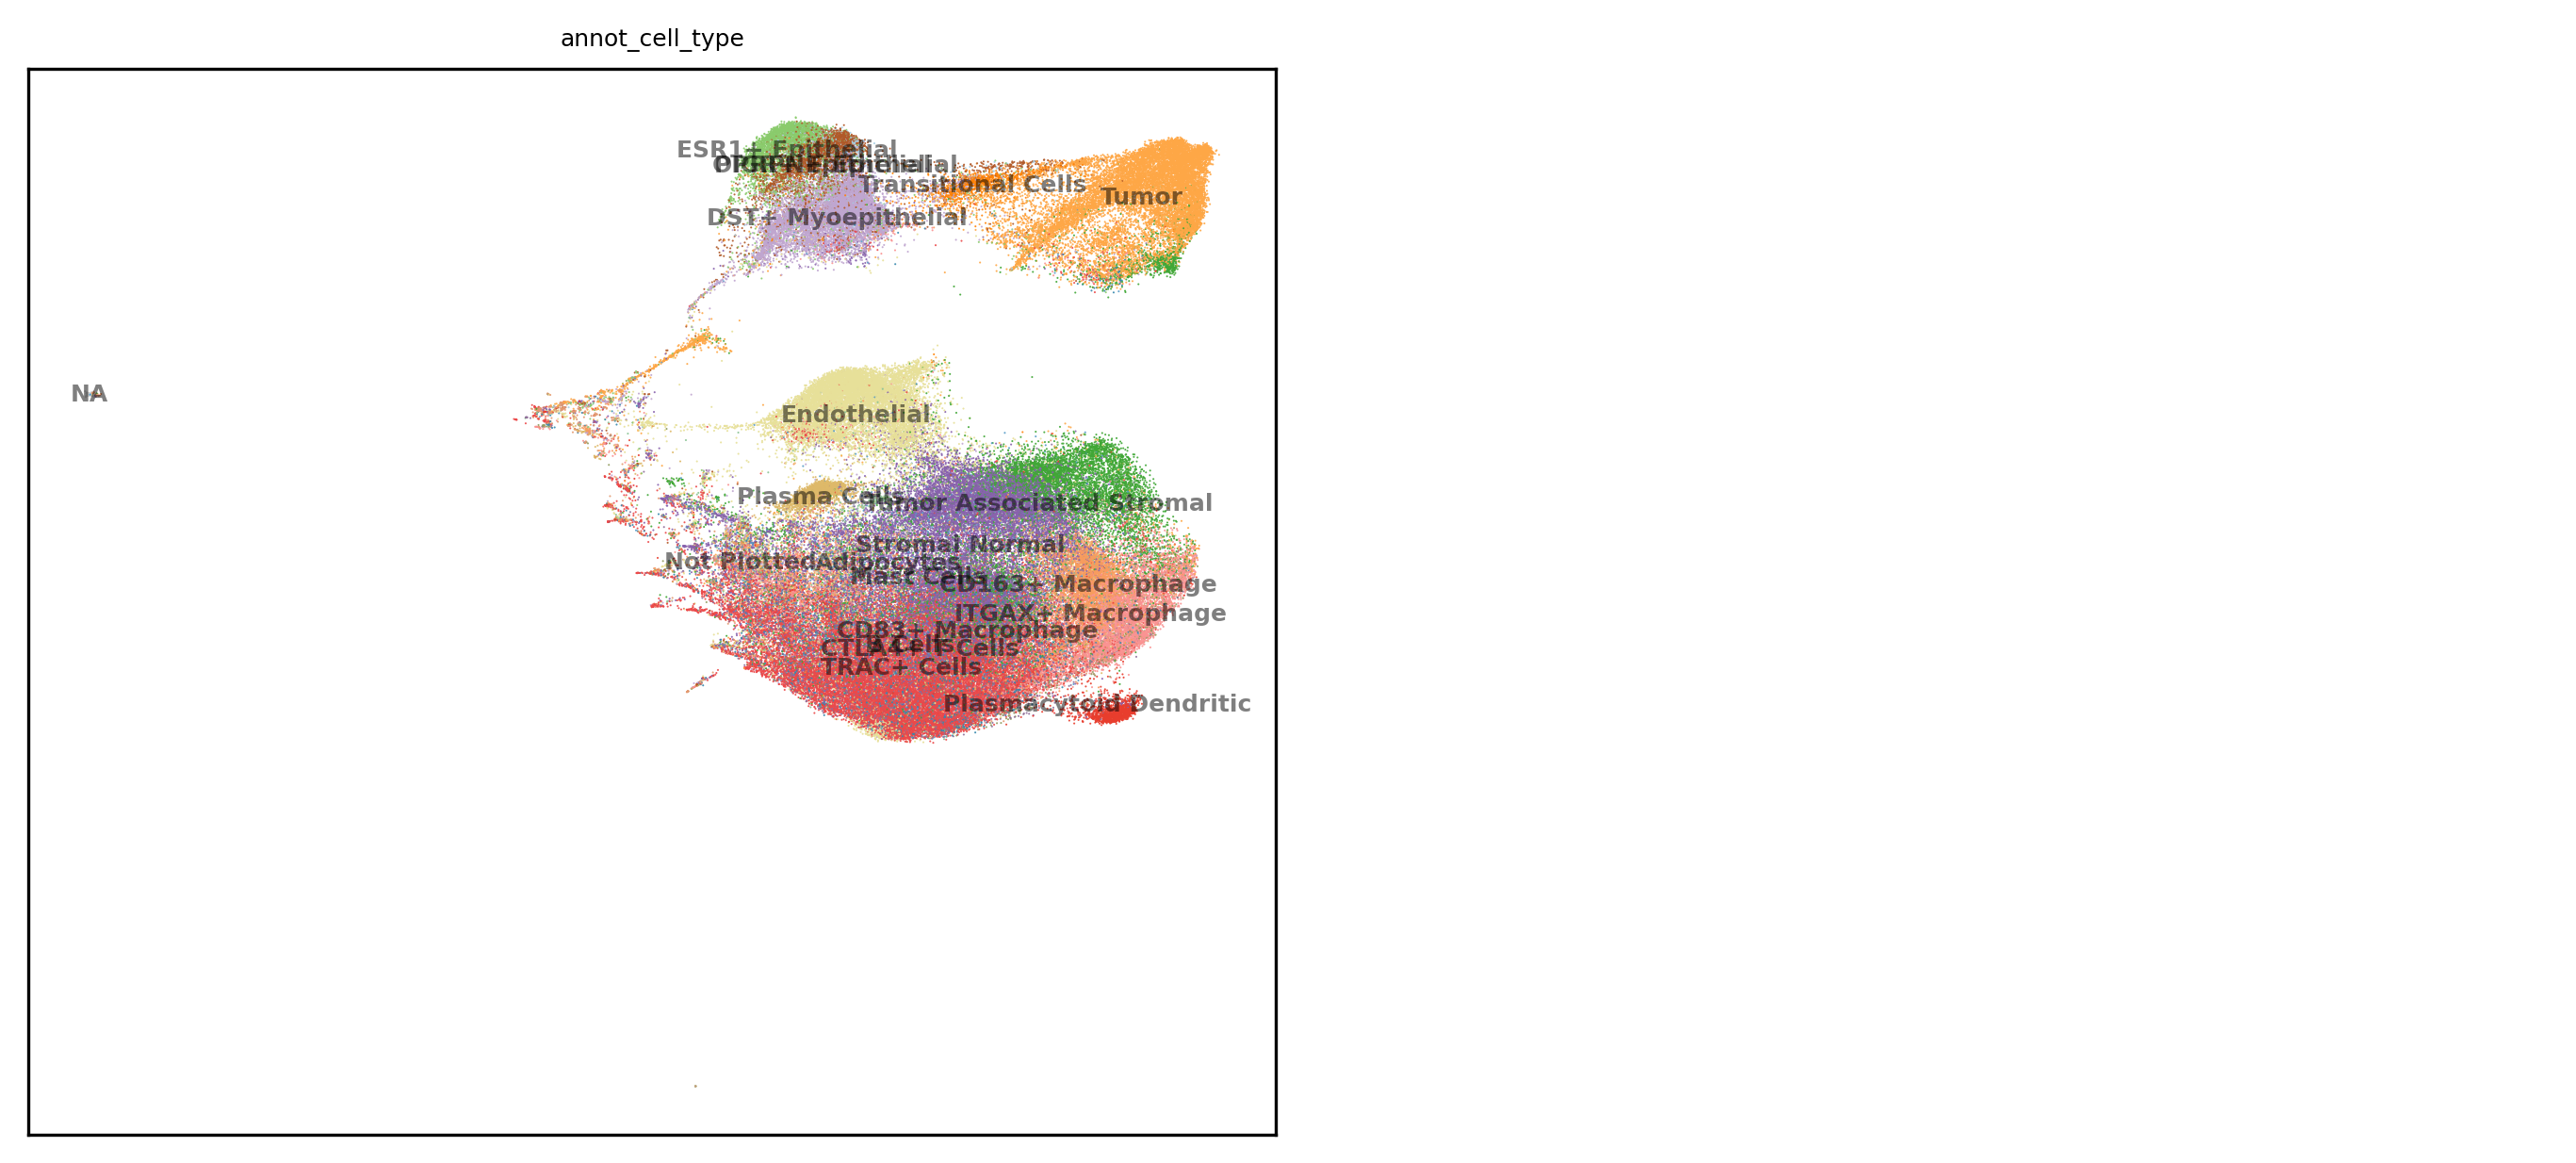

In [24]:
import concord as ccd
_, _, ct_pal = ccd.pl.get_color_mapping(xenium_sp2_adata, 'annot_cell_type', pal='Paired', seed=1)
pal = {'annot_cell_type':ct_pal}
show_basis = f'X_umap'
show_cols = ['annot_cell_type']
ccd.pl.plot_embedding(
    xenium_sp2_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2,  font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"xenium_sp2_embeddings_{show_basis}_{file_suffix}.png"
)

In [25]:
import concord as ccd
cur_ccd = ccd.Concord(adata=xenium_sp2_adata, 
                      latent_dim = n_latent,
                      save_dir=save_dir, # directory to save model checkpoints
                      inplace=False, # whether to modify adata in place
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
xenium_sp2_adata.obsm = cur_ccd.adata.obsm.copy()
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"xenium_sp2_obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.3


Epoch 0 Training: 2223it [00:07, 289.49it/s, loss=3.71]
Epoch 9 Training: 100%|██████████| 2223/2223 [00:07<00:00, 296.73it/s, loss=3.76]


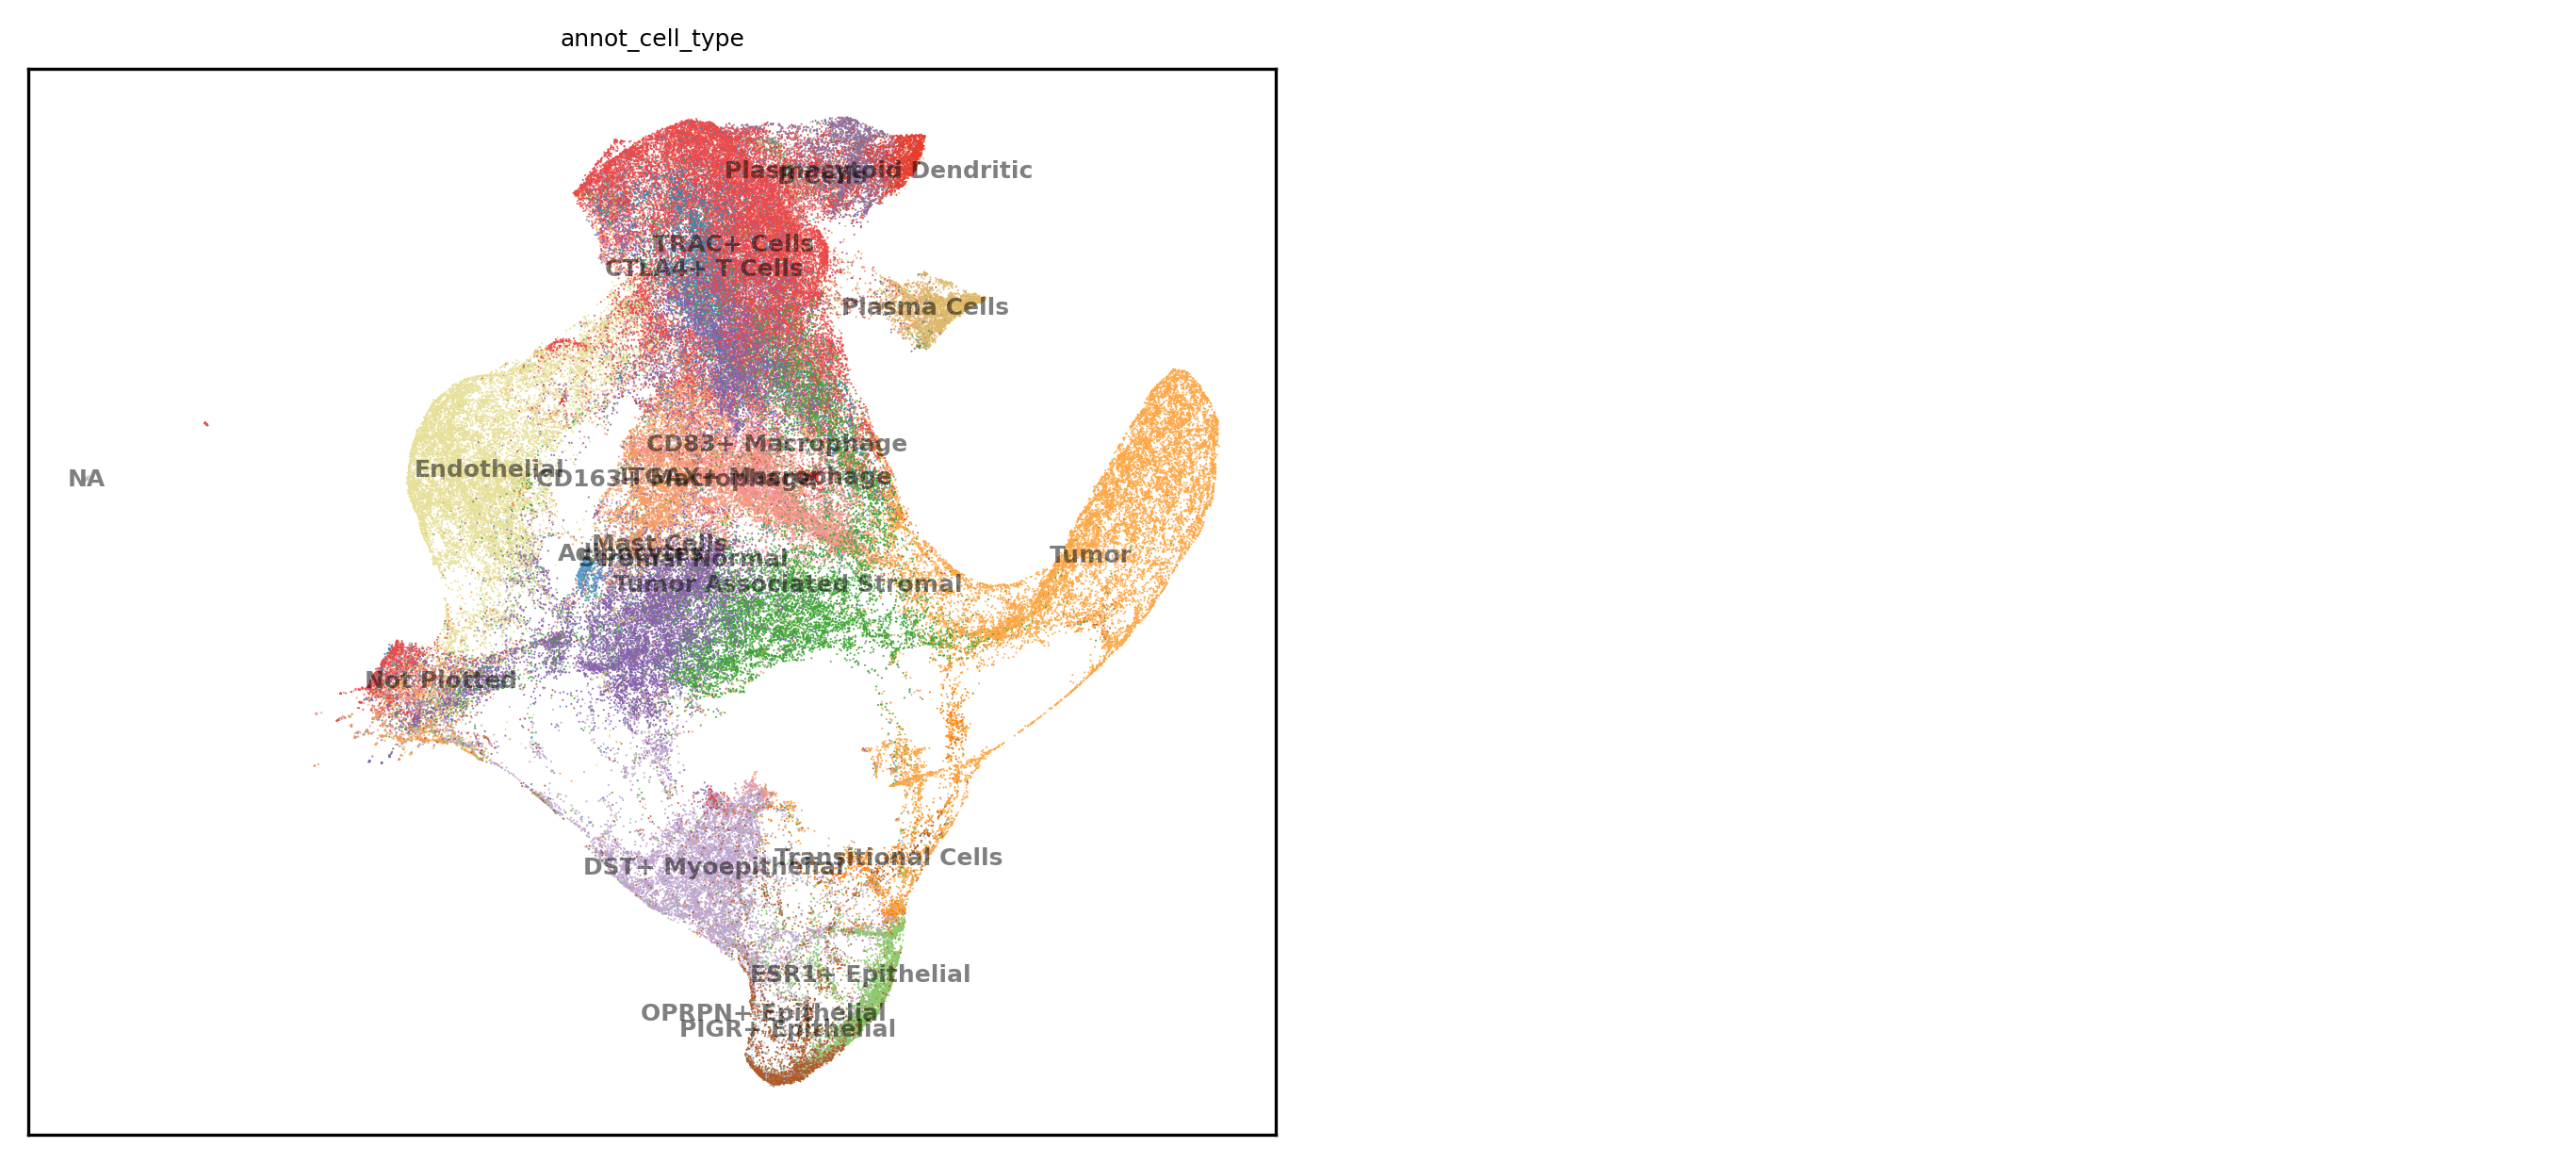

In [26]:
# compute umap
ccd.ul.run_umap(xenium_sp2_adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
show_basis = f'{output_key}_UMAP'
show_cols = ['annot_cell_type']
ccd.pl.plot_embedding(
    xenium_sp2_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2, font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"xenium_sp2_embeddings_{show_basis}_{file_suffix}.png"
)

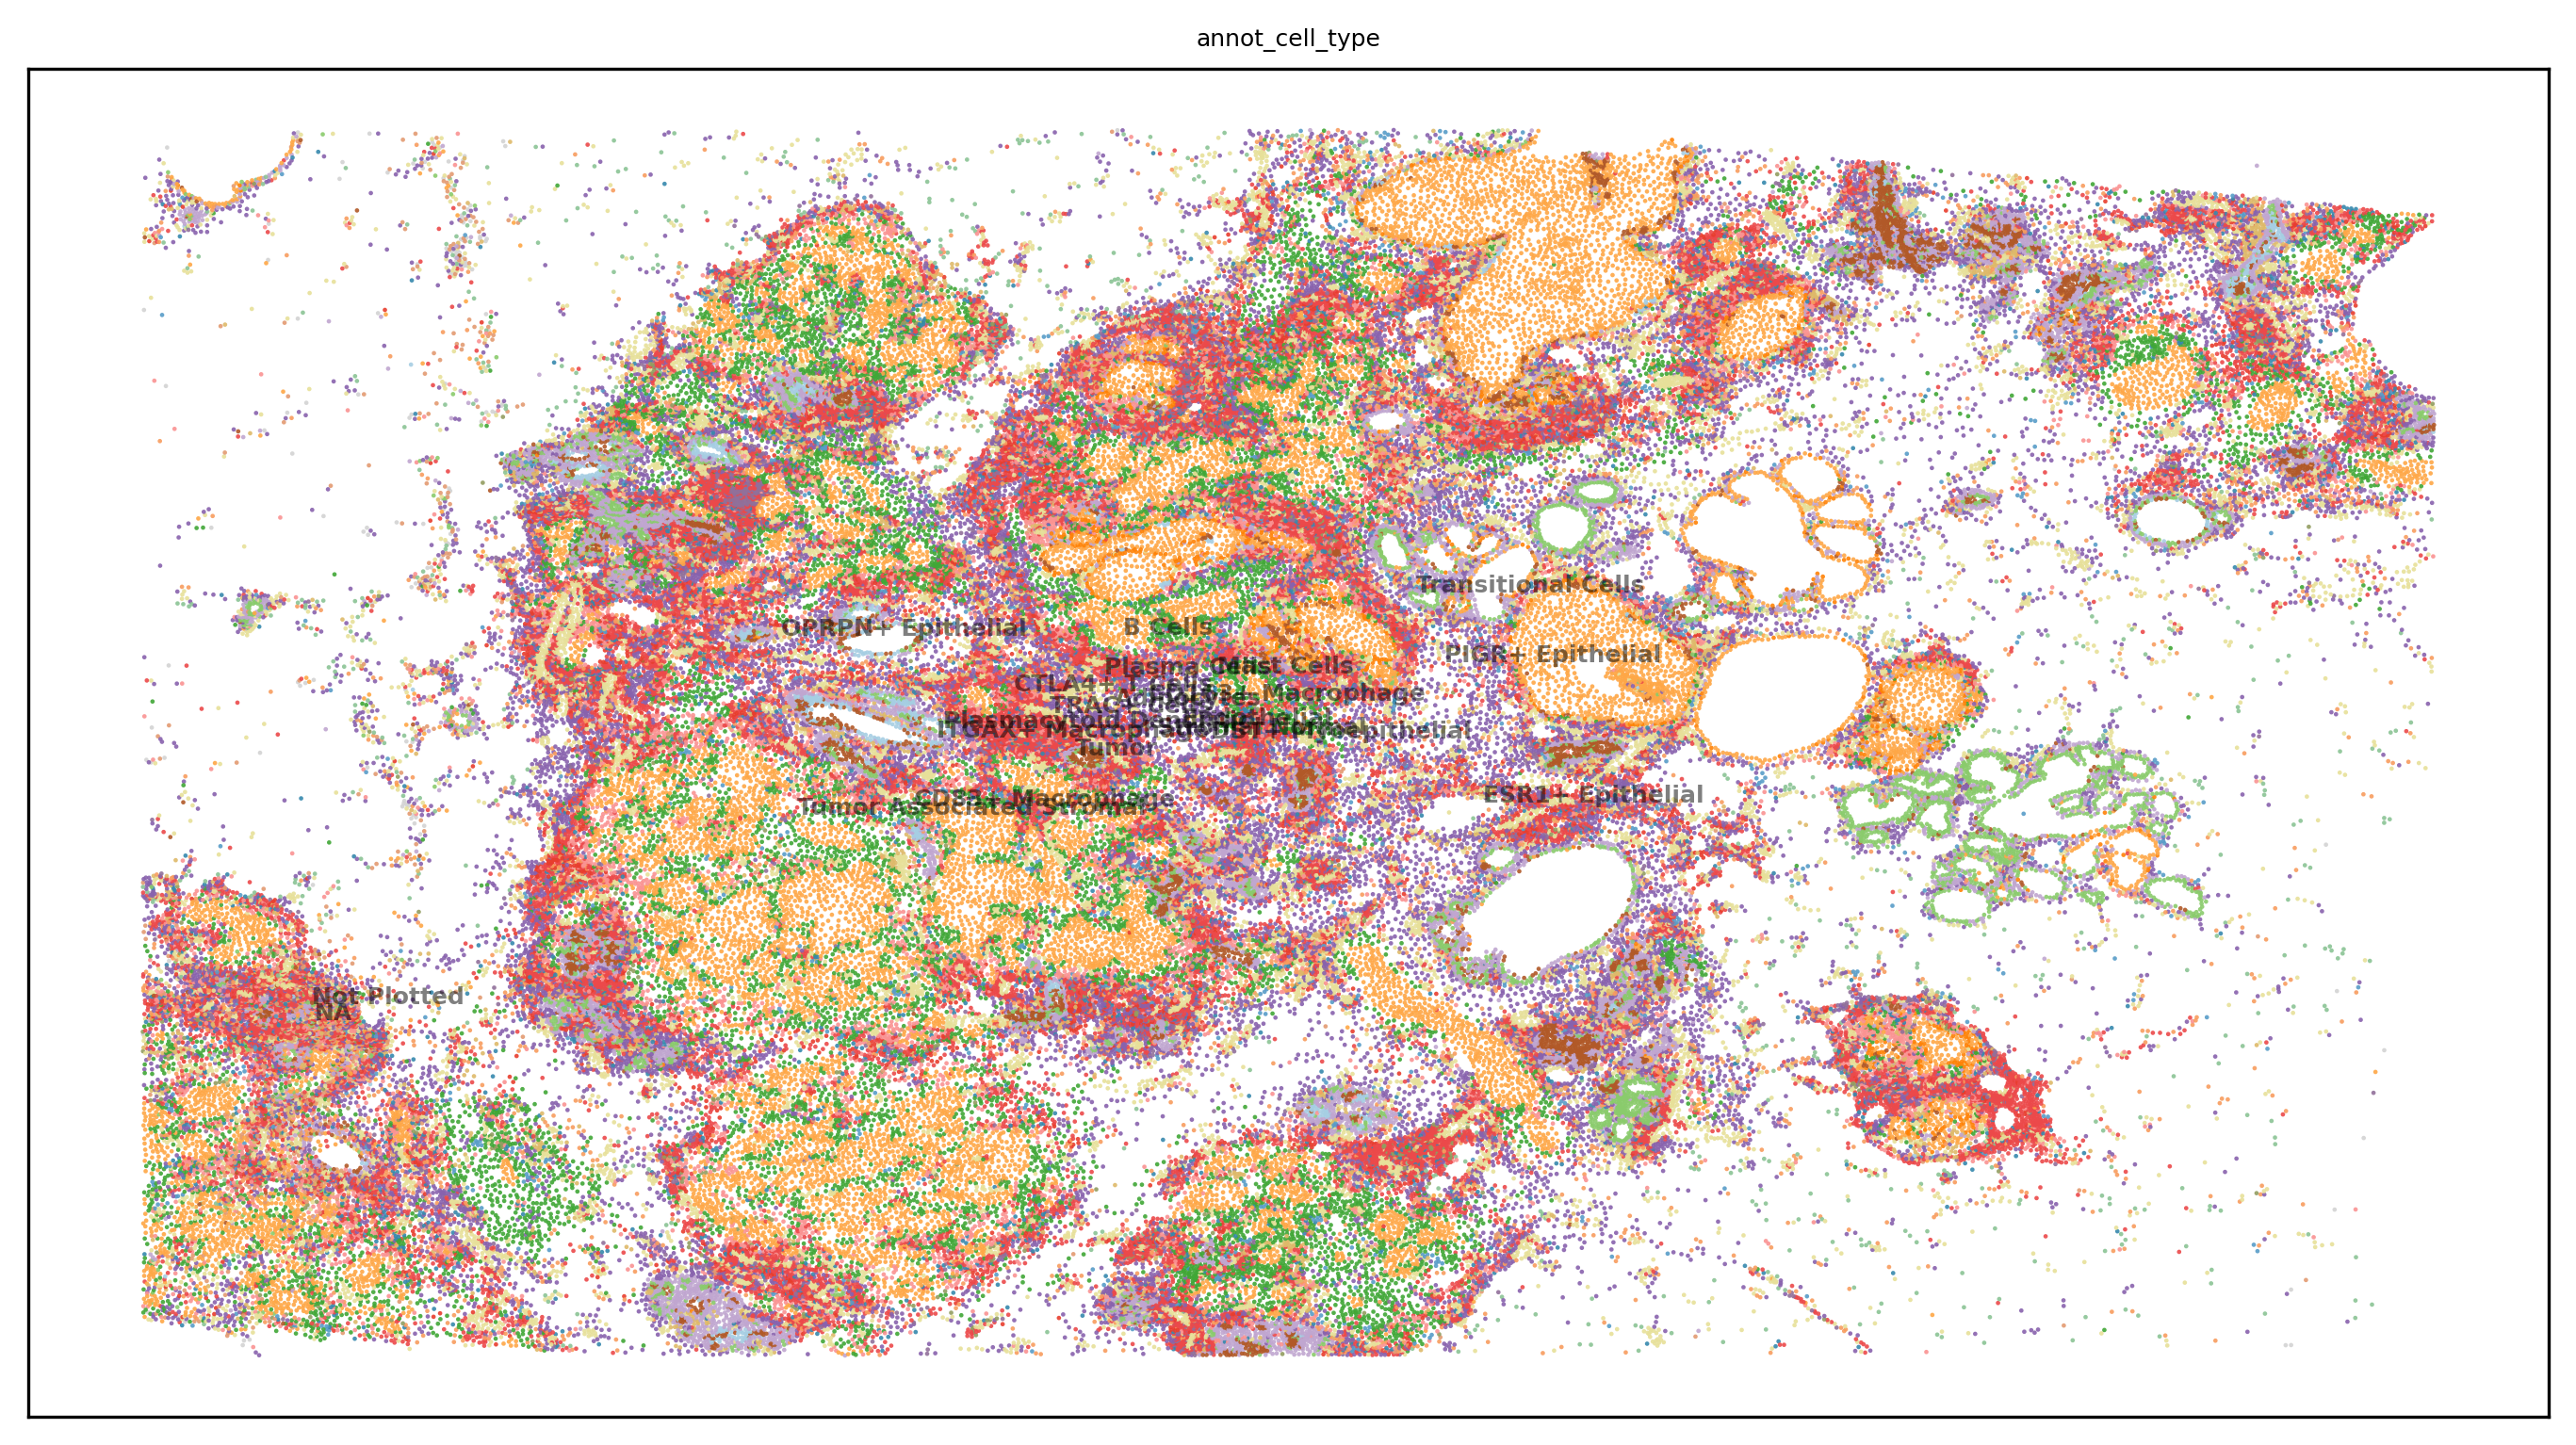

In [27]:
xenium_sp2_adata.obsm['Xenium_centroid'] = xenium_sp2_cell_info[['x_centroid', 'y_centroid']].values
show_basis = f'Xenium_centroid'
show_cols = ['annot_cell_type']
ccd.pl.plot_embedding(
    xenium_sp2_adata, show_basis, show_cols, figsize=(9,5), dpi=300, ncols=1, font_size=6, point_size=5, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"xenium_sp2_{show_basis}_{file_suffix}.png"
)

In [28]:
xenium_sp2_adata.obs['replicate'] = 'rep1'
xenium_sp2_adata.obs_names = "xenium_sp2_" + xenium_sp2_adata.obs_names.astype(str)
xenium_sp2_adata.write_h5ad(data_dir / f"xenium_sp2_adata_{file_suffix}.h5ad")
print(f"Saved xenium_sp2_adata to {data_dir / f'xenium_sp2_adata_{file_suffix}.h5ad'}")
ccd.ul.anndata_to_viscello(xenium_sp2_adata, data_dir / f"cello_xenium_sp2_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_xenium_sp2_{proj_name}_{file_suffix}.h5ad'}")


Saved xenium_sp2_adata to ../data/janesick_nature_comms_2023/xenium_sp2_adata_Jun05-2014.h5ad
VisCello project created at ../data/janesick_nature_comms_2023/cello_xenium_sp2_janesick_nc_2023_dev_sample2_Jun05-2014
Saved viscello to ../data/janesick_nature_comms_2023/cello_xenium_sp2_janesick_nc_2023_dev_sample2_Jun05-2014.h5ad
